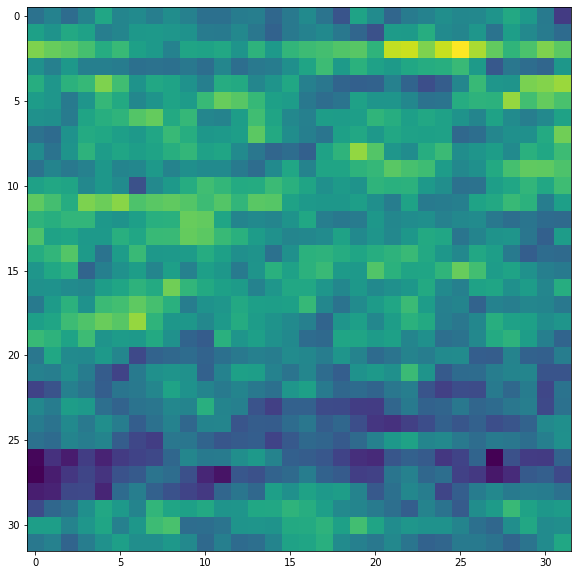

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import time
from PIL import Image, ImageOps
from scipy.linalg import hadamard
from os.path import join

rc = "racecar.jpg"
br = "5.png"
path = "rollingball"

raw_img = cv2.imread(rc)
#raw_img = cv2.imread(br)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)
#gray_img = cv2.resize(gray_img, (sz,sz)) 

# Convert to number array
objs = np.array(gray_img)
    
imsize = 32**2

# Make measurements
#obj_br = np.reshape(jointimg, (32,96)) #Reshape to a vector to make maths easier
I = np.identity(imsize)
H = hadamard(imsize)
m = np.zeros((imsize,1))

PatternSet  =  H; # Chose H or I here.

length = 50
# Measure for each pattern
for i in range(0,imsize):                                  # for each pixel value
    a = round(i*(length/imsize))                           # i*(50/32^2) - moving through diff sections
    obj = objs[:,a:a+32]                                   # now obj changes for each measurement
    #print(a)
    
    samplingVector = PatternSet[i,:]                       # row index of pattern matrix and all columns - choosing each row from iden/hadamard matrix
    samplingPattern = np.reshape(samplingVector,(32,32))   # reshaping to image size, for each i the 1 moves along the rows of the matrices - reshapes each row of iden/hadamard matrix to sz x sz
    #plt.imshow(obj)                                       # shows the rasterscan in action, each coord being moved thru
    #plt.show()
    #time.sleep(0.005)
    m[i] = np.sum(samplingPattern * obj)                   # taking measurements, sum of patterns*image, there's a pattern for each zero in the zero array m - puts obj as a column vector basically
    #print(m)

# Reconstruct Image
recon = np.matmul(PatternSet,m)                    
recon = np.reshape(recon, (32,32))
plt.rcParams['figure.figsize'] = [18,10] # set the image size
fig = plt.imshow(recon)

Above is the processing of a racecar image with dimensions 96x32 pixels, because the quality is so poor it is hard to make out any details. Below is the same processing but now with the same image at a quality of 192x64 pixels, taking sections of size 64x64:

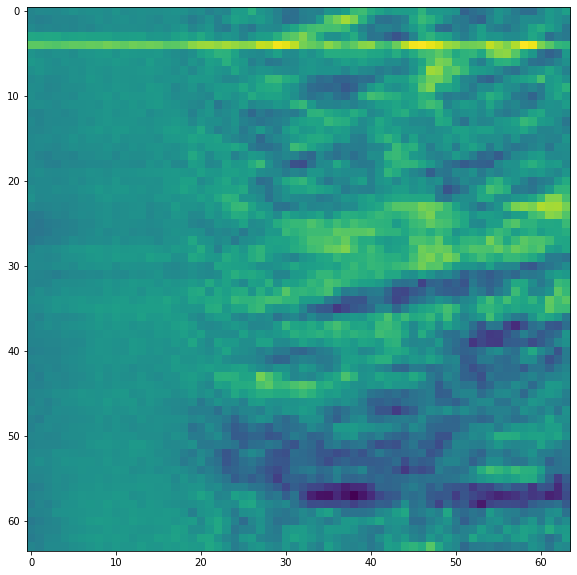

In [5]:
rc64 = "racecar64.jpg"
raw_img = cv2.imread(rc64)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)

# Convert to number array
objs = np.array(gray_img)
    
imsize = 64**2

# Make measurements
I = np.identity(imsize)
H = hadamard(imsize)
m = np.zeros((imsize,1))

PatternSet  =  H; # Chose H or I here.

length = 10                      # Image appears more smeared the higher this number is - object is 'moving' faster - max is 128
allobjs = []
# Measure for each pattern
for i in range(0,imsize):                                  # for each pixel value
    a = round(i*(length/imsize))                           # i*(50/32^2) - moving through diff sections
    obj = objs[:,a:a+64]                                   # now obj changes for each measurement - simulates moving object
    allobjs.append(obj)
    #print(a)
    
    samplingVector = PatternSet[i,:]                       # row index of pattern matrix and all columns - choosing each row from iden/hadamard matrix
    samplingPattern = np.reshape(samplingVector,(64,64))   # reshaping to image size, for each i the 1 moves along the rows of the matrices - reshapes each row of iden/hadamard matrix to sz x sz
    #plt.imshow(obj)                                       # shows the rasterscan in action, each coord being moved thru
    #plt.show()
    #time.sleep(0.005)
    m[i] = np.sum(samplingPattern * obj)                   # taking measurements, sum of patterns*image, there's a pattern for each zero in the zero array m - puts obj as a column vector basically
    #print(m)

# Reconstruct Image
recon = np.matmul(PatternSet,m)                    
recon = np.reshape(recon, (64,64))
plt.rcParams['figure.figsize'] = [18,10] # set the image size
fig = plt.imshow(recon)

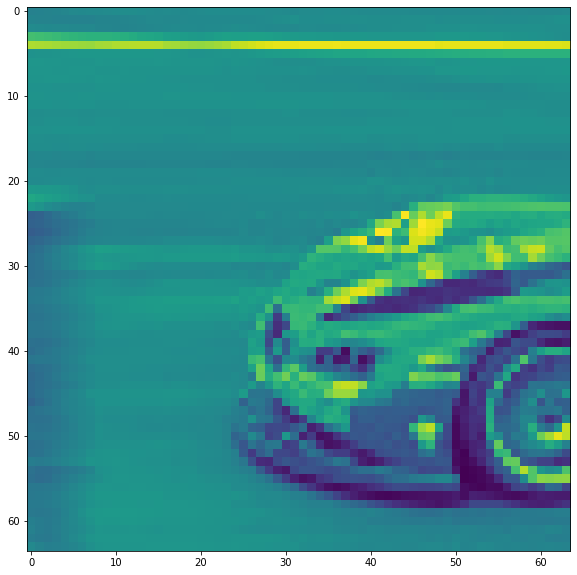

In [6]:
plt.imshow(allobjs[0]) # just seeing what the last obj looks like 
plt.show()

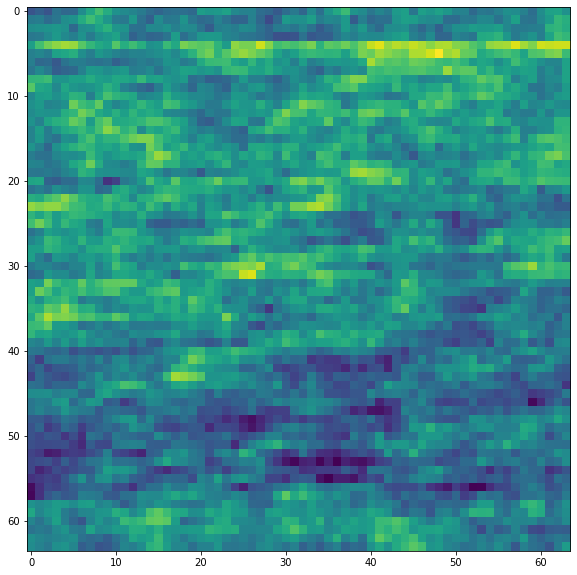

In [7]:
# Measure for each pattern
lengths = [1,50,100,128]

recons = []
for x in lengths:

    for i in range(0,imsize):                                  # for each pixel value
        a = round(i*(x/imsize))                           # i*(50/32^2) - moving through diff sections
        obj = objs[:,a:a+64]                                   # now obj changes for each measurement - simulates moving object
        allobjs.append(obj)
        #print(a)
    
        samplingVector = PatternSet[i,:]                       # row index of pattern matrix and all columns - choosing each row from iden/hadamard matrix
        samplingPattern = np.reshape(samplingVector,(64,64))   # reshaping to image size, for each i the 1 moves along the rows of the matrices - reshapes each row of iden/hadamard matrix to sz x sz
        #plt.imshow(obj)                                       # shows the rasterscan in action, each coord being moved thru
        #plt.show()
        #time.sleep(0.005)
        m[i] = np.sum(samplingPattern * obj)                   # taking measurements, sum of patterns*image, there's a pattern for each zero in the zero array m - puts obj as a column vector basically
        #print(m)

    # Reconstruct Image
    recon = np.matmul(PatternSet,m)                    
    recon = np.reshape(recon, (64,64))
    recons.append(recon)
    #plt.rcParams['figure.figsize'] = [18,10] # set the image size
    plt.imshow(recon)
    
# was trying to plot each img in a subplot:
    
#fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
#axs[0,0].imshow(recons[0])
#axs[0,1].imshow(recons[1])
#axs[1,0].imshow(recons[2])
#axs[1,1].imshow(recons[3])

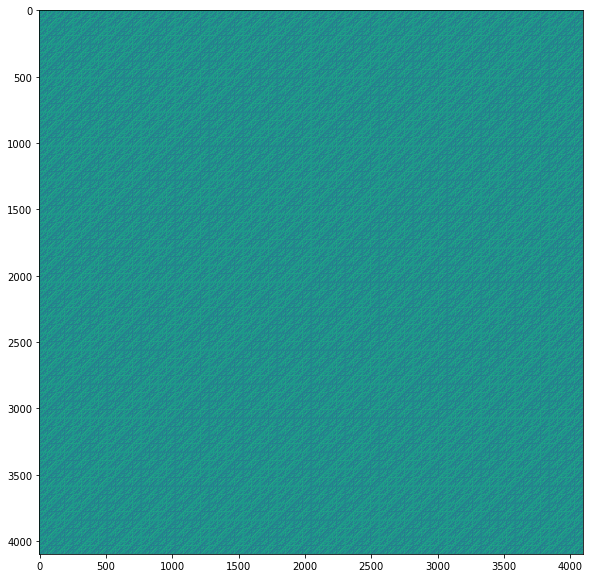

In [8]:
sz = 64    
imsize = sz**2

H = hadamard(imsize)
plt.imshow(H)


# Ordering the hadamard in terms of frequency

In [12]:
patterns = []           # creating empty arrays to bring the patterns and freqs out the loop
freqs = []

for i in range(0,imsize):
    pattern = np.reshape(H[:,i],(sz,sz))
    freq = (np.sum(np.abs(np.diff(pattern,axis=0))) + np.sum(np.abs(np.diff(pattern,axis=1))))/8
    patterns.append(pattern)
    freqs.append(freq)
    #plt.imshow(pattern)
    #plt.title(['Spatial Changes = ', str(freq)])
    #plt.show()

patterns = np.array(patterns)    # changing the lists to numpy arrays
freqs = np.array(freqs)
inds = freqs.argsort()           # sorting pattern matrices by the frequency number
sorted_h = patterns[inds]
sorted_freqs = sorted(freqs)        

Now checking the patterns did actually get sorted. Hashed out because it takes a while to run:

In [43]:
#for i,j in zip(sorted_h,sorted_freqs):
#    plt.imshow(i)
#    plt.title(['Spatial Changes = ', str(j)])
    #plt.show()

Now trying to use each hadamard pattern in order of sorted_h, throws up an error when trying to reshape the sampling vector:

In [44]:
rc64 = "racecar64.jpg"
raw_img = cv2.imread(rc64)
gray_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2GRAY)

# Convert to number array
objs = np.array(gray_img)
    
imsize = 64**2

# Make measurements
m = np.zeros((imsize,1))

PatternSet  =  H; # Chose H or I here.

length = 10                      # Image appears more smeared the higher this number is - object is 'moving' faster - max is 128

allobjs = []
for i,j in zip(sorted_h,(range(0,imsize))):
    a = round(j*(length/imsize))
    obj = objs[:,a:a+64]
    allobjs.append(obj)
    samplingVector = i[j,:]
    #print(samplingVector)
    samplingPattern = np.reshape(samplingVector,(64,64))
    m[j] = np.sum(samplingPattern*obj)
    

ValueError: cannot reshape array of size 64 into shape (64,64)

In [38]:
len(PatternSet[0])

4096

In [47]:
len(sorted_h[0])

64

In [39]:
imsize

4096